# Annotate Mitosis Events (and other cell events)
In this tutorial, we will guide you through how to annotate mitosis events, though the workflow can be applied to various other cell events. By the end, you will have a clear understanding of how to load and process imaging datasets, correct segmentations, track single cells, and interactively annotate them using Napari UI.

Author: Ke

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cellpose import models
from cellpose.io import imread
import glob
from pathlib import Path
from PIL import Image, ImageSequence
from tqdm import tqdm
import os
import os.path
# from livecellx import segment
from livecellx import core
from livecellx.core import datasets
from livecellx.core.datasets import LiveCellImageDataset, SingleImageDataset
from skimage import measure
from livecellx.core import SingleCellTrajectory, SingleCellStatic
# import detectron2
# from detectron2.utils.logger import setup_logger

# setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import cv2


## Loading single cells from existing mask files

When specifying mask_dataset_path, it's crucial to note that file names should be alphabetically sorted to maintain the correct order of times. This order is essential to ensure the proper temporal sequence of events. If your data filenames don't follow this pattern, you'll need to supply LiveCellImageDataset with a time2url dictionary, which maps time information to file locations.

In [2]:
dataset_dir_path = Path(
    "../datasets/test_data_STAV-A549/DIC_data"
)

mask_dataset_path = Path("../datasets/test_data_STAV-A549/mask_data")

# dataset_dir_path = Path(
#     "../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/XY16/"
# )

# mask_dataset_path = Path("../datasets/EBSS_Starvation/tif_STAV-A549_VIM_24hours_NoTreat_NA_YL_Ti2e_2022-12-21/out/XY16/seg")
# raw_image_dir_path = Path(
#     "../datasets/tutorial_data_EBSS_mitosis/raw_images"
# )

# mask_dataset_path = Path("../datasets/tutorial_data_EBSS_mitosis/label_masks")


### Loading the mask dataset

We'll now load the mask dataset using the LiveCellImageDataset class. This dataset helps segment the cells in our images.

In [3]:
mask_dataset = LiveCellImageDataset(mask_dataset_path, ext="png")
len(mask_dataset)

3 png img file paths loaded;


3

### Organizing and loading DIC images

Next, we organize and load the DIC images which give us a detailed and contrasting view of cell boundaries.

In [5]:
time2url = sorted(glob.glob(str((Path(dataset_dir_path) / Path("*_DIC.tif")))))
time2url = {i: path for i, path in enumerate(time2url)}
dic_dataset = LiveCellImageDataset(time2url=time2url, ext="tif")
# dic_dataset = LiveCellImageDataset(dataset_dir_path, ext="tif")

We check that the number of DIC images matches the number of masks.

In [6]:
len(dic_dataset)

3

### Converting label masks to single objects
We can convert the provided label masks into individual single cell objects:

In [7]:
from skimage.measure import regionprops
from livecellx.core.io_sc import prep_scs_from_mask_dataset
single_cells = prep_scs_from_mask_dataset(mask_dataset, dic_dataset)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:10<00:00,  3.58s/it]


We display the mask dataset names of first two single cell objects.

In [8]:
single_cells[0].mask_dataset.name, single_cells[1].mask_dataset.name

('0fe9d08f-4cc9-4ae3-9925-687fcc88f3ec',
 '0fe9d08f-4cc9-4ae3-9925-687fcc88f3ec')

We aim to organize the single cell datasets based on the timeframes they belong to.

In [9]:
single_cells_by_time = {}
for cell in single_cells:
    if cell.timeframe not in single_cells_by_time:
        single_cells_by_time[cell.timeframe] = []
    single_cells_by_time[cell.timeframe].append(cell)

## Correcting single cell segmentation before tracking
Sometimes, segmentations might not be perfect, and you might need to correct them manually or programmatically:

In [10]:
from livecellx.core.single_cell import SingleCellTrajectoryCollection
temp_sc_trajs_for_correct = SingleCellTrajectoryCollection()
for idx, sc in enumerate(single_cells):
    sct = SingleCellTrajectory(track_id = idx, timeframe_to_single_cell={sc.timeframe: sc})
    temp_sc_trajs_for_correct.add_trajectory(sct)


In [12]:
# load csn model
from livecellx.core.sc_seg_operator import ScSegOperator
ckpt_path = r"C:\Users\13290\Documents\Single-cell\LiveCell\LiveCellTracker-dev\notebooks\csn_models\v11-01_epoch=229-best.ckpt"
ScSegOperator.load_default_csn_model(path=ckpt_path, cuda=True);

Lightning automatically upgraded your loaded checkpoint from v1.8.6 to v2.0.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file C:\Users\13290\Documents\Single-cell\LiveCell\LiveCellTracker-dev\notebooks\csn_models\v11-01_epoch=229-best.ckpt`
c:\Users\13290\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\13290\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet50_Weights.DEFAULT` to get the most up-to-date we

>>> Using BCE loss with logits loss
>>> Based on loss type, training output threshold:  0.5


## Tracking based on single cells
To establish trajectories based on single cells:

In [13]:
from typing import List
from livecellx.track.sort_tracker_utils import (
    gen_SORT_detections_input_from_contours,
    update_traj_collection_by_SORT_tracker_detection,
    track_SORT_bbox_from_contours,
    track_SORT_bbox_from_scs
)


traj_collection = track_SORT_bbox_from_scs(single_cells, dic_dataset, mask_dataset=mask_dataset, max_age=1, min_hits=1)

### Trajectory Length Histogram

<Axes: xlabel='Trajectory Length', ylabel='count'>

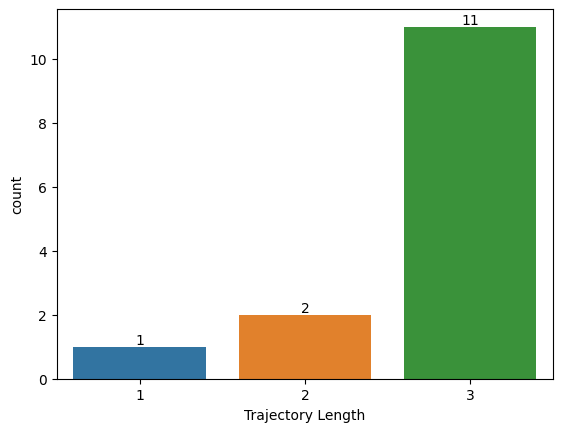

In [14]:
traj_collection.histogram_traj_length()

## Visualizing and annotating in Napari UI
Using the Napari UI, you can visually inspect and annotate single cell trajectories. This is an interactive step:

In [15]:
%gui qt
import napari
import numpy as np
from skimage import data
from napari.viewer import Viewer
from livecellx.core.napari_visualizer import NapariVisualizer, Visualizer
from livecellx.core.single_cell import SingleCellStatic, SingleCellTrajectory, SingleCellTrajectoryCollection


### Manually or programmatically correct trajectories via SctOperator

In [17]:
import napari
from livecellx.core.sct_operator import SctOperator, create_sct_napari_ui
viewer = napari.view_image(dic_dataset.to_dask(), name="dic_image", cache=True)
shape_layer = NapariVisualizer.gen_trajectories_shapes(traj_collection, viewer, contour_sample_num=20)
shape_layer.mode = "select"

sct_operator = SctOperator(traj_collection, shape_layer, viewer)
# sct_operator.setup_shape_layer(shape_layer)
create_sct_napari_ui(sct_operator)

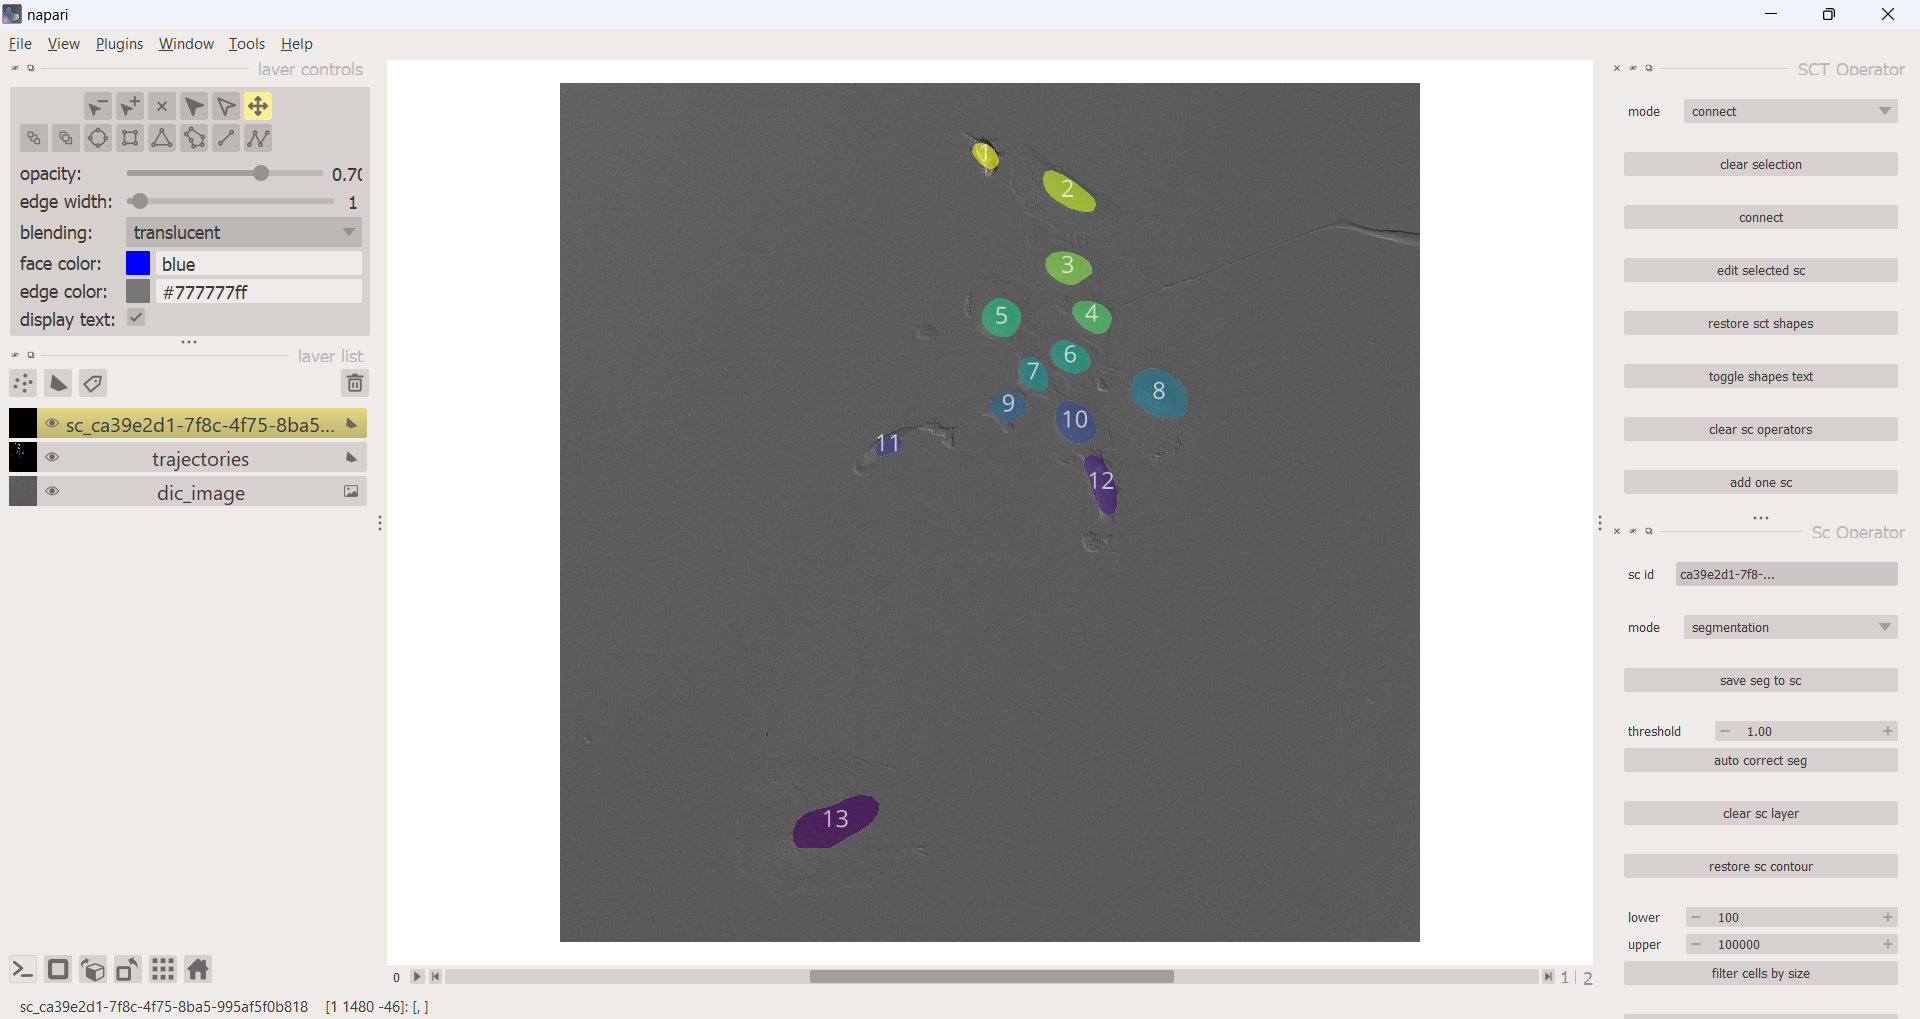

Now please annotate some cells in the napari UI by choosing "click&annotate"

In [19]:
!mkdir "test_sample_out\\mitosis_samples"

## Saving annotations
Save your annotations programmatically for further analysis:

In [20]:
sample_out_dir = Path("./test_sample_out")
sample_dataset_dir = sample_out_dir / "datasets"
filename_pattern = "sample_{sample_index}.json"
sample_paths = sct_operator.save_annotations(sample_out_dir / "mitosis_samples", filename_pattern, sample_dataset_dir=sample_dataset_dir)

<saving annotations>
|-----> saving scs
<saving annotations complete>


To verify that the samples were saved correctly:

In [ ]:
# Load and Check if samples are saved successfully
sample_path = sample_paths[0]
sample = SingleCellStatic.load_single_cells_json(sample_path, dataset_json_dir = sample_dataset_dir)
print(sample)

In [ ]:
SingleCellStatic.write_single_cells_json(single_cells, sample_out_dir / "all_cells.json" ,dataset_dir = sample_dataset_dir)